In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
with open('TactileCAAE/latent_dict.pickle', 'rb') as file:
    feat_dict = pickle.load(file)

In [3]:
from munkres import Munkres,print_matrix

def best_map(L1,L2):
    #L1 should be the labels and L2 should be the clustering number we got
    Label1 = np.unique(L1)       # 去除重复的元素，由小大大排列
    nClass1 = len(Label1)        # 标签的大小
    Label2 = np.unique(L2)       
    nClass2 = len(Label2)
    nClass = np.maximum(nClass1,nClass2)
    G = np.zeros((nClass,nClass))
    for i in range(nClass1):
        ind_cla1 = L1 == Label1[i]
        ind_cla1 = ind_cla1.astype(float)
        for j in range(nClass2):
            ind_cla2 = L2 == Label2[j]
            ind_cla2 = ind_cla2.astype(float)
            G[i,j] = np.sum(ind_cla2 * ind_cla1)
    m = Munkres()
    index = m.compute(-G.T)
    index = np.array(index)
    c = index[:,1]
    newL2 = np.zeros(L2.shape)
    for i in range(nClass2):
        newL2[L2 == Label2[i]] = Label1[c[i]]
    return newL2

In [5]:
from sklearn.cluster import KMeans
pred_acc = 0
pred_labels = []
for i in range(500):
    kmeans = KMeans(n_clusters=14, n_init="auto").fit(feat_dict['z'])
    kmeans_labels = best_map(feat_dict['label'], kmeans.labels_)
    acc = (np.array(kmeans_labels) == feat_dict['label']).sum() / len(feat_dict['label'])
    if acc >= pred_acc:
        pred_acc = acc
        pred_labels = kmeans_labels   
pred_acc

0.9435049019607843

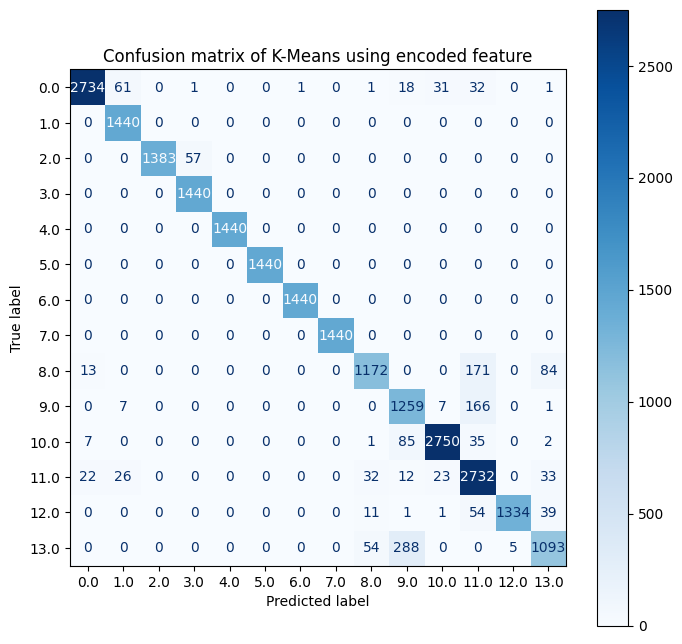

In [58]:
conf_matrix = confusion_matrix(feat_dict['label'], pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=list(set(feat_dict['label'])))

fig, ax = plt.subplots(figsize=(8,8))
plt.title('Confusion matrix of K-Means using encoded feature')

disp.plot(
    include_values=True,
    cmap="Blues",
    ax=ax,
    xticks_rotation="horizontal",
    values_format="d"
)

In [61]:
conf_matrix

array([[2734,   61,    0,    1,    0,    0,    1,    0,    1,   18,   31,
          32,    0,    1],
       [   0, 1440,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0, 1383,   57,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0, 1440,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0, 1440,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0, 1440,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 1440,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 1440,    0,    0,    0,
           0,    0,    0],
       [  13,    0,    0,    0,    0,    0,    0,    0, 1172,    0,    0,
         171,    0,   84],
       [   0,    7,    0,    0,    0,    0,    0,    0,    0, 1259,    7,
         166,    

In [9]:
import os
import librosa
from sklearn import preprocessing

real_data_path = 'Reference_Waves/'
fake_data_path = 'Generated_Waves/'

real_file_list = []
for root, dirs, files in os.walk(real_data_path):
    for name in files:
        real_file_list.append(os.path.join(root, name))
        
fake_file_list = []
for root, dirs, files in os.walk(fake_data_path):
    for name in files:
        fake_file_list.append(os.path.join(root, name))

In [55]:
data = {'data': [], 
        'label': []}

for file in real_file_list:
    d, fs = librosa.load(file, sr=44100)
    data['data'].append(d[:int(44100*1.5)])
    data['label'].append(file.split('/')[-1][:2]+'Real')

fake_data = {'data': [], 
             'label': []}

for file in fake_file_list:
    d, fs = librosa.load(file, sr=44100)
    fake_data['data'].append(d[:int(44100*1.5)])
    fake_data['label'].append(file.split('\\')[-1][:2]+'Fake')

data['label'].extend(fake_data['label'])
data['data'].extend(fake_data['data'])

In [56]:
tsne = TSNE(n_components=2, perplexity=25, init='pca')

X = np.array(data['data'])
print(X.shape)
X_tsne = tsne.fit_transform(X)

(30, 66150)


C:\Users\zmxle\AppData\Local\Temp\ipykernel_73156\2723219430.py:11: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


Text(0, 0.5, '')

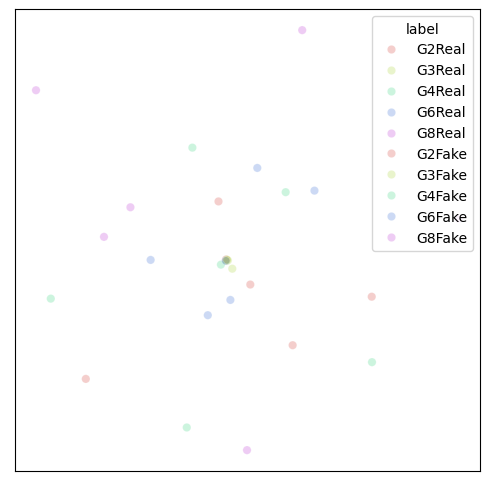

In [57]:
import seaborn as sns
import pandas as pd

plt_data = pd.DataFrame()

plt_data['tsne_x'] = X_tsne[:,0]
plt_data['tsne_y'] = X_tsne[:,1]
plt_data['label'] = data['label']

plt.figure(figsize=(6,6))
sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="label",
    palette=sns.color_palette("hls", 5),
    data=plt_data,
    legend="full",
    alpha=0.3
)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')